In [1]:

import os
import urllib
import sys

import numpy as np

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB.PDBIO import PDBIO

def check_structure_seq(InDir):
    
    PepBuilder = PPBuilder()
    parser = PDBParser(PERMISSIVE=1, QUIET=True)

    seq = {}
    for InPDB in os.listdir(InDir):

        if InPDB.endswith(".pdb"):
            InStruct = parser.get_structure("target", f"{InDir}/{InPDB}")
            InSeq = str(PepBuilder.build_peptides(InStruct)[0].get_sequence())

            if InSeq in seq:
                seq[InSeq].append(InPDB)
            else:
                seq[InSeq] = [InPDB]
            # print(InPDB, InSeq)

    print(seq)

    return

def check_atom(InDir):
    
    parser = PDBParser(PERMISSIVE=1, QUIET=True)
    Natoms_dict = {}

    for InPDB in os.listdir(InDir):

        if InPDB.endswith(".pdb"):
            InStruct = parser.get_structure("target", f"{InDir}/{InPDB}")
            # print(InStruct[0]["A"].child_list)
            Natoms = []
            
            for resi in InStruct[0]["A"].child_list:
                Natoms.append(len(resi.child_list))
            
            Natoms = "".join(map(str, Natoms))
            # sum_atoms = sum(Natoms)
            
            # if sum_atoms in Natoms_dict:
            #     Natoms_dict[sum_atoms].append(InPDB)
            # else:
            #     Natoms_dict[sum_atoms] = [InPDB]

            if Natoms in Natoms_dict:
                Natoms_dict[Natoms].append(InPDB)
            else:
                Natoms_dict[Natoms] = [InPDB]
        # break

    print(Natoms_dict)
    return

In [2]:
def download_from_IMGT(PDB_id_list:list, OutDir:str):

    if not os.path.exists(OutDir):
        os.makedirs(OutDir)
        
    for i, id in enumerate(PDB_id_list):
        print(f"Downloading: {id}  {i+1}/{len(PDB_id_list)}")
        urllib.request.urlretrieve(f"http://www.imgt.org/3Dstructure-DB/IMGT-FILE/IMGT-{id.upper()}.pdb.gz", f"{OutDir}/{id}.pdb.gz")

    return

In [3]:
# class atom():
#     def __init__(self, coord:list) -> None:
#         self.coord = coord
#         pass

#     def rmsd_per_atom(self):
#         return

class Residue():
    def __init__(self,residue_name: str, atom_coord_dict: dict) -> None:
        self.resname = residue_name
        self.coord = atom_coord_dict
        self.dist = {}
        pass

    def list_atoms(self):
        return list(self.coord.keys())

    def symmetry_swap(self):
        if self.resname == "ARG":
            self.coord["NH1"], self.coord["NH2"] = self.coord["NH2"], self.coord["NH1"]

        elif self.resname == "ASP":
            self.coord["OD1"], self.coord["OD2"] = self.coord["OD2"], self.coord["OD1"]

        elif self.resname == "PHE":
            self.coord["CD1"], self.coord["CD2"] = self.coord["CD2"], self.coord["CD1"]
            self.coord["CE1"], self.coord["CE2"] = self.coord["CE2"], self.coord["CE1"]

        elif self.resname == "GLU":
            self.coord["OE1"], self.coord["OE2"] = self.coord["OE2"], self.coord["OE1"]

        elif self.resname == "LEU":
            self.coord["CD1"], self.coord["CD2"] = self.coord["CD2"], self.coord["CD1"]

        elif self.resname == "TYR":
            self.coord["CD1"], self.coord["CD2"] = self.coord["CD2"], self.coord["CD1"]
            self.coord["CE1"], self.coord["CE2"] = self.coord["CE2"], self.coord["CE1"]

        elif self.resname == "VAL":
            self.coord["CG1"], self.coord["CG2"] = self.coord["CG2"], self.coord["CG1"]

        return

    def calc_dist(self, ref_coord_dict):
        # check if have same atoms
        if self.coord.keys() != ref_coord_dict.keys():
            raise ValueError(f"residue have different atoms! ref: {list(ref_coord_dict.coord.keys())} object: {list(self.coord.keys())}")
        
        for atom in ref_coord_dict:
            distance = np.linalg.norm(ref_coord_dict[atom]-self.coord[atom])
            self.dist[atom] = distance

        return

    def resi_dist_sum(self):
        return sum(self.dist.values())

    def coord_flat(self, ref_coord_dict):
        flat_coord = []
        for atom in ref_coord_dict:
            flat_coord.append(self.coord[atom])
        return flat_coord

    def dist_flat(self, ref_coord_dict):
        flat_dist = []
        for atom in ref_coord_dict:
            flat_dist.append(self.dist[atom])
        return flat_dist

    def update_coord(self, coord_list):
        # for ref struct
        if len(self.coord) != len(coord_list):
            raise ValueError("coord_list doesn't match!")

        for coord, atom in zip(coord_list, self.coord.keys()):
            self.coord[atom] = coord

    def update_dist(self, dist_list):
        if len(self.dist) != len(dist_list):
            raise ValueError("dist_list doesn't match!")

        for dist, atom in zip(dist_list, self.dist.keys()):
            self.dist[atom] = dist

class Chain():
    
    def __init__(self, chain) -> None:
        self.chain = chain
        pass

    @classmethod
    def from_pdb(cls, InPDB):
        resi_list = []
        parser = PDBParser(PERMISSIVE=1, QUIET=True)
        InStruct = parser.get_structure("target", InPDB)

        for resi in InStruct[0]["A"]:
            atom_coord_dict = {}

            for atom in resi:
                atom_coord_dict[atom.id] = atom.coord

            resi_list.append(Residue(resi.resname, atom_coord_dict))
            # cls.add_residue(cls, resi.resname, atom_coord_dict)

        return Chain(resi_list)

    def symmetry_refine(self, ref_chain):

        for resiT, resiR in zip(self.chain, ref_chain.chain):
            if resiT.resname in ["ARG", "ASP", "PHE", "GLU", "LEU", "TYR", "VAL"]:
                resiT.calc_dist(resiR.coord)
                old_dist = resiT.resi_dist_sum()
                
                resiT.symmetry_swap()
                
                resiT.calc_dist(resiR.coord)
                new_dist = resiT.resi_dist_sum()
                if old_dist <= new_dist:
                    resiT.symmetry_swap() # flip back

        return

    def calc_dist(self, ref_chain):
        dist_list = []
        
        for resiT, resiR in zip(self.chain, ref_chain.chain):
            resiT.calc_dist(resiR.coord)
            dist_list.append(resiT.resi_dist_sum())

        return dist_list

    def coord_flat(self, ref_chain):
        flat_coord = []
        
        for resiT, resiR in zip(self.chain, ref_chain.chain):
            flat_coord += resiT.coord_flat(resiR.coord)
        
        return flat_coord

    def dist_flat(self, ref_chain):
        flat_dist = []

        for resiT, resiR in zip(self.chain, ref_chain.chain):
            flat_dist += resiT.dist_flat(resiR.coord)

        return flat_dist

    def update_coord_from_list(self, coord_list):

        # check atom numbers
        AtomSum = 0
        for resi in self.chain:
            AtomSum += len(resi.list_atoms())

        if AtomSum != len(coord_list):
            raise ValueError("check coord list!!")
        start = 0
        for resi in self.chain:
            Natoms = len(resi.coord)
            resi.update_coord(coord_list[start:start+Natoms])
            start += Natoms

        return

class RMSF():
    def __init__(self) -> None:
        pass

    @classmethod
    def RMSF_from_dir(cls, InDir, outPDB="RMSF.pdb"):
        
        cls.get_mean_struct(cls, InDir, outPDB)
        
        # cls.save_PDB_rmsf(cls, f"{InDir}/{outPDB}")
        
        return

    def get_mean_struct(self, InDir, outPDB):
        struct_collect = []
        coord_collect = []
        for PDBfile in os.listdir(InDir):
            if PDBfile.endswith(".pdb"):
                # print(PDBfile)
                struct_collect.append(Chain.from_pdb(f"{InDir}/{PDBfile}"))

        # round 1: rough calculation

        ref_chain = Chain.from_pdb(f"{InDir}/{PDBfile}") # use the last pdb file as template

        for struct in struct_collect:
            coord_collect.append(struct.coord_flat(ref_chain))

        ref_coord = np.mean(coord_collect, axis=0).round(3)
        ref_chain.update_coord_from_list(ref_coord)

        # round 2: flip symmetrical residues to decrease rmsd
        coord_collect = []
        dist_collect = []

        for struct in struct_collect:
            struct.symmetry_refine(ref_chain)
            coord_collect.append(struct.coord_flat(ref_chain))

        # rebuild mean structure
        ref_coord = np.mean(coord_collect, axis=0).round(3)
        ref_chain.update_coord_from_list(ref_coord)

        # calculate rmsf
        for struct in struct_collect:
            struct.calc_dist(ref_chain)
            dist_collect.append(struct.dist_flat(ref_chain))

        rmsf = np.sqrt(np.sum(dist_collect, axis=0)/len(coord_collect)).round(3)
        # print(len(rmsf))
        # sys.exit()

        self.save_PDB_rmsf(self, f"{InDir}/{PDBfile}", ref_coord, rmsf, outPDB)

        return
        """
        if g.resn=='ARG':
        switchName("flippedRes", "NH1", "NH2")
        elif g.resn=='HIS':
        switchName("flippedRes", "ND1", "CD2")
        switchName("flippedRes", "CE1", "NE2")
        elif g.resn=='ASP':
        switchName("flippedRes", "OD1", "OD2")
        elif g.resn=='PHE':
        switchName("flippedRes", "CD1", "CD2")
        switchName("flippedRes", "CE1", "CE2")
        elif g.resn=='GLN':
        switchName("flippedRes", "OE1", "NE2")
        elif g.resn=='GLU':
        switchName("flippedRes", "OE1", "OE2")
        elif g.resn=='LEU':
        switchName("flippedRes", "CD1", "CD2")
        elif g.resn=='ASN':
        switchName("flippedRes", "OD1", "ND2")
        elif g.resn=='TYR':
        switchName("flippedRes", "CD1", "CD2")
        switchName("flippedRes", "CE1", "CE2")
        elif g.resn=='VAL':
        switchName("flippedRes", "CG1", "CG2")
        """

    def save_PDB_rmsf(self, ref_PDB, coord_list, rmsf_list, out_PDB):
        parser = PDBParser(PERMISSIVE=1, QUIET=True)
        Struct = parser.get_structure("target", ref_PDB)

        for atom, coord, rmsf in zip(Struct[0]["A"].get_atoms(), coord_list, rmsf_list):
            atom.set_coord(coord)
            atom.set_bfactor(rmsf)

        io = PDBIO()
        io.set_structure(Struct)
        io.save(out_PDB)
        
        return

In [253]:
## HLA-A

id_list = ["3bo8","4nqx","1w72","4nqv","6at9"] #A0101
# id_list = ["6j2a","6j29","6j1v"] #A3003
# id_list = ["6j1w"] #A3001

# id_list = ["3mre","3d25","6trn","5n1y","1i4f","6o53","4u6y","5ddh","6o4z","2gtw","6o51","6o4y","2v2w","2v2x","2vll","3bgm","3gso","3pwn","3v5h","3bh8","3fqn","3kla","3pwl","3utq",
# "3qfd","4u6x","2git","2gtz","3bh9","3fqr","3fqx","3o3d","3pwj","2gt9","6opd","1duz","1i7u","1tvb","1tvh","3fqt","3fqu","3ft2","3gsu","3o3a","3gsw","1jf1","3o3e","5enw","3h7b","5mer",
# "3myj","1t1z","2guo","2x4q","3ft4","3gjf","3gsv","3o3b","3rew","5hhp","6pte","3fqw","2av1","3ft3","3gsr","1t1y","2clr","2x70","3giv","3hpj","3v5d","4k7f","5swq","5hhn","2av7","2x4u",
# "3gsx","3ixa","5hhq","4uq3","3gsq","1duy","1jht","6ptb","1t21","1i1y","1i7r","1im3","1qew","1s8d","1s9w","1t1w","1t1x","1t20","1t22","3bhb","3i6g","3mgt","6apn","1eey","1eez","1s9y",
# "2x4o","2x4p","2x4r","2x4t","3mgo","3v5k","2x4n","2c7u","1qr1","1b0g","1hhi","1hhj","1hhk","1s9x","5hhm","2x4s","1hhg","3hla","3to2","1akj","5mep","1i1f","1i7t","3i6k","1b0r","3gjg",
# "3hae","5hho","1hhh","4wuu","6nca","1p7q","1hla","3h9h","3mrg","3mrb","3mrk","3mrr","3mrd","3mrc","3mrj","3mrm","3mr9","3mri","3mrp","3mrq","3mrf","3mrn","3mro","3mrh","3mrl","4jfo",
# "4jfp","4jfq","2j8u","2uwe","2jcc","2p5e","2p5w","3hg1","1lp9","3utt","3uts","2bnq","2bnr","2f54","2f53","3qfj","2gj6","1ao7","3pwp","3h9s","1qrn","1qse","1qsf","3d3v","3d39","6rsy",
# "3o4l","1bd2","2pye","3qeq","3qdm","3qdj","3qdg","6tro","1oga","2vlr","2vlj","2vlk","6rpb","6rpa","6rp9","3gsn","5tez","5yxn","5yxu"] #A0201
# id_list = ["3ox8"] #A0203
# id_list = ["5f1i"] #A0205
# id_list = ["3oxr","6p64"] #A0206
# id_list = ["3oxs"] #A0207

# id_list = ["3rl1","3rl2","2xpg","6eny"] #A0301
# id_list = ["1x7q","2hn7","1qvo","1q94","4beo","4uq2","4n8v"] #A1101
# id_list = ["1hsb","2hla"] #A6801

# id_list = ["5wwj","5wwu","5wwi","5xov"] #A2301
# id_list = ["4f7t","4f7p","3vxn","5hgd","5hga","5wxc","3nfn","5hgh","3i6l","4f7m","5hgb","3vxp","3vxo","2bck","3qzw","5wxd","3nfj","3vxm","3vxs","3vxr","3w0w","3vxu"] #A2402


download_from_IMGT(id_list, "A0101")

In [254]:
## HLA-B

# id_list = ["6at5","6avf","6avg","4u1h","3vcl","5eo0","5eo1","4u1k"] # B0702
# id_list = ["1xh3","2fyy","1zhk","4prn","1zsd","2cik","3lko","3lkp","3lkq","4pr5","4pra","2h6p","3lks","1a1n","2axg","3lkn","3lkr","4lnr","1a9e","1cg9","4qrr","1a9b","2nx5","3mv7","3mv8","4prp","3mv9"] # B3501
# id_list = ["4u1m","4u1j"] # B4201
# id_list = ["1e27","1e28","4mji"] # B5101
# id_list = ["1a1m","1a1o"] # B5301

# id_list = ["3spv","4qrs","4qrt","6p2c","6p2f","6p27","4qru","6p23","6p2s","4qrq","3skm","3x13","1m05","3x14","1agd","1agc","1agb","1agf","1age","3sko","3ffc","4qrp","1mi5","3sjv"] # B0801

# id_list = ["3bxn","3bvn"] # B1402
# id_list = ["6pyl","6pz5"] # B2703
# id_list = ["5def"] # B2704
# id_list = ["5ib2","5ib1","5ib3","5ib4","5ib5","6pyj","4g8i","4g9d","3b6s","3bp4","3lv3","2bss","2bst","3dtx","1w0v","2bsr","4g9f","4g8g"] # B2705
# id_list = ["5deg"] # B2706
# id_list = ["1k5n","3czf","1uxw","3d18","3bp7","3b3i","1jgd","3hcv","1w0w","1of2"] # B2709
# id_list = ["4o2c","4o2f","4o2e"] # B3901

# id_list = ["6mt3","4xxc"] # B1801
# id_list = ["6mt6","6mt4","6mt5","6mtm"] # B3701
# id_list = ["6iex"] # B4001
# id_list = ["5iek"] # B4002
# id_list = ["1m6o","3kpm","3dx6","3l3i","3l3d","3kpl","3l3g","3l3j","3l3k"] # B4402
# id_list = ["3dx7","1n2r","3kpn","3kpo","1sys"] # B4403

# id_list = ["6d29","6d2t","6bxp","6bxq","5vue","6d2r","5vuf","5vud","3vh8","3x12","3upr","3wuw","6d2b","5b38","2rfx","5b39"] #B5701
# id_list = ["5vwh","5vwj","5ind","5im7","5inc"] # B5801

# id_list = ["5txs","1xr9","3c9n","1xr8","5vz5"] # B1501
# id_list = ["4lcy"] # B4601


# download_from_IMGT(id_list, "B4601")

Downloading: 4lcy  1/1


In [4]:
for allele in ["A0101", "A0201", "A3003", "A3001", "A0203", "A0205", "A0206", "A0207", "A0301", "A1101", "A6801", "A2301", "A2402"]:

    print(allele)
    name = allele[0:3]+"_"+allele[3:5]+"_rmsf.pdb"
    # check_structure_seq("A0101/A0101_ALIGN")
    # check_atom("A0101/A0101_ALIGN")
    RMSF.RMSF_from_dir(f"../crystal/{allele}/ALIGN", name)

A0101
A0201
A3003
A3001
A0203
A0205
A0206
A0207
A0301
A1101
A6801
A2301
A2402


In [279]:
# for allele in ["B0702","B3501","B4201","B5101","B5301","B0801","B1402","B2703","B2704","B2705","B2706","B2709","B3901","B1801","B3701","B4001","B4002","B4402","B4403","B5701","B5801","B1501","B4601"]:
for allele in ["B0801"]:
    print(allele)
    name = allele[0:3]+"_"+allele[3:5]+"_rmsf.pdb"
    RMSF.RMSF_from_dir(f"{allele}/ALIGN2", name)

B0801


In [308]:
import matplotlib.pyplot as plt
contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171]
# contactB = [5,7,8,9,24,45,59,62,63,65,66,67,70,73,74,76,77,80,81,84,95,97,99,114,116,123,143,146,147,152,155,156,159,160,163,167,171]

B_list = ["B07_02", "B08_01", "B15_01", "B27_05", "B27_09", "B35_01", "B37_01", "B39_01", "B44_02", "B44_03", "B57_01", "B58_01"]
def sum_rmsf(InDir, AlleleList):
    
    parser = PDBParser(PERMISSIVE=1, QUIET=True)
    fig = plt.figure(figsize=(24,8), facecolor="w")

    mean_rmsf_collect = []

    for allele in AlleleList:
        mean_rmsf_list = []
        resi_id_list = []
        InStruct = parser.get_structure("target", f"{InDir}/{allele}.pdb")
        # print(InStruct[0]["A"].child_list)
        
        for resi in InStruct[0]["A"].child_list:
            resi_list = []
            for atom in resi:
                resi_list.append(atom.bfactor)

            resi_id_list.append(resi.id[1])
            mean_rmsf_list.append(np.mean(resi_list))

        plt.plot(resi_id_list, mean_rmsf_list, label=allele)

        # print(rmsf_list)
        mean_rmsf_collect.append(mean_rmsf_list)

    plt.legend()
    plt.vlines(contact, 0, 2, linestyles="dashed")
    plt.show()

    fig = plt.figure(figsize=(24,8), facecolor="w")
    std_list = np.std(np.transpose(mean_rmsf_collect), axis=1)
    mean_list = np.mean(np.transpose(mean_rmsf_collect), axis=1)
    plt.errorbar(resi_id_list, mean_list, std_list)
    plt.vlines(contact, 0, 2, linestyles="dashed")
    plt.show()

    return mean_rmsf_collect

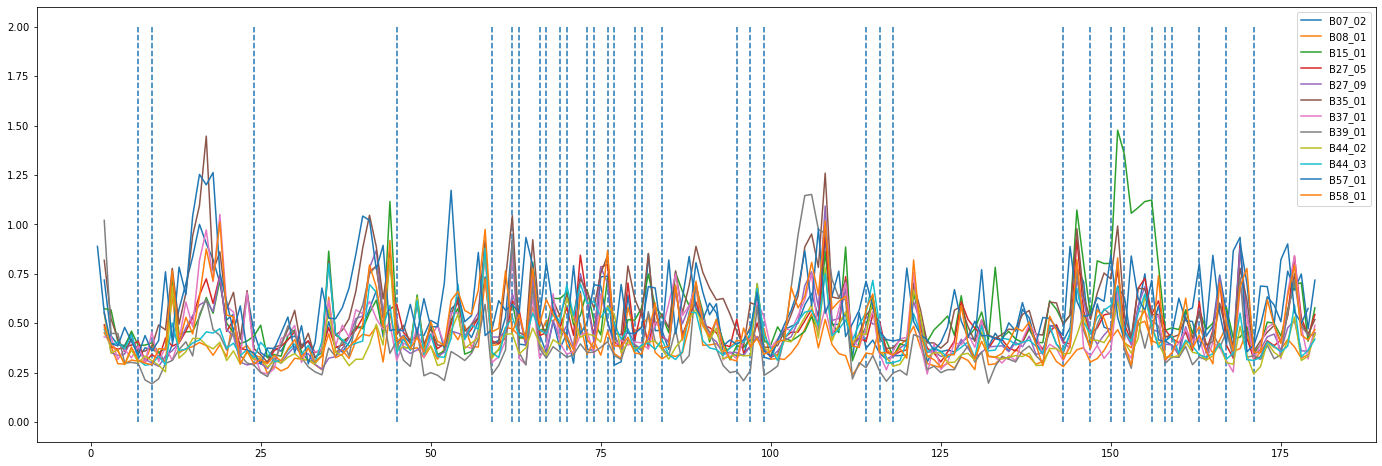

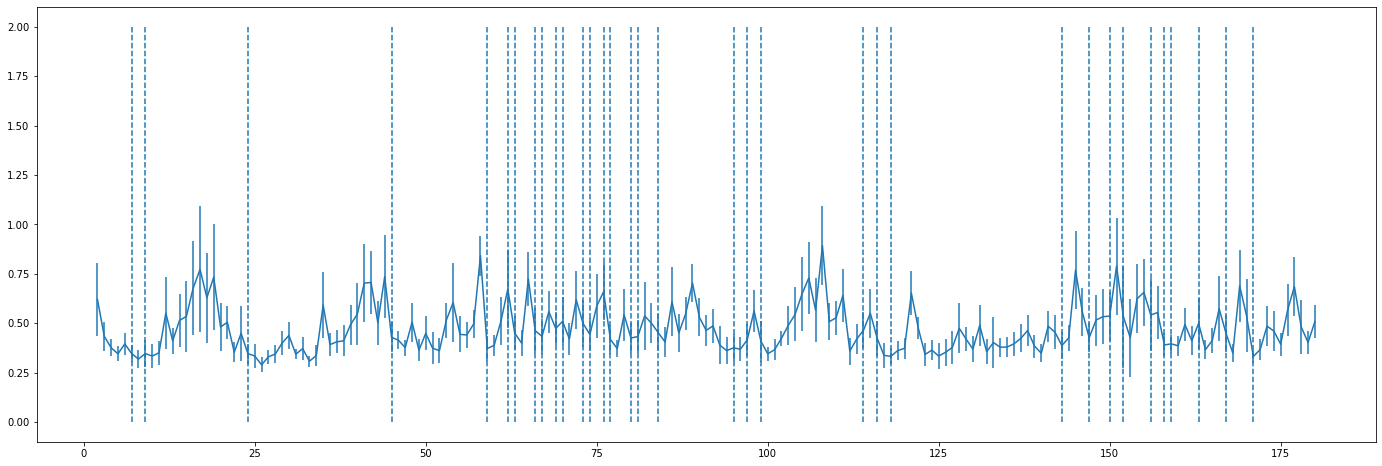

In [309]:
mean_rmsf_collect = sum_rmsf("B_mean/pdb", B_list)

In [296]:
np.std(np.transpose(mean_rmsf_collect), axis=1)

(179,)